# Predicting Buying Session - EDA

## Init

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
import seaborn as sns

In [2]:
from sklearn.preprocessing import LabelEncoder
import scipy.stats as ss

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [3]:
df = pd.read_csv('online_shoppers_intention.csv')

In [4]:
num_feats = ['Administrative', 'Administrative_Duration', 'Informational', 
             'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 
             'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']

In [5]:
obj_feats = ['Month', 'OperatingSystems', 'Browser', 'Region',
             'TrafficType', 'VisitorType']
df[obj_feats] = df[obj_feats].astype('object')

cat_feats = ['Month', 'OperatingSystems', 'Browser', 'Region',
             'TrafficType', 'VisitorType', 'Weekend']

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  object 
 12  Browser                  12330 non-null  object 
 13  Region                   12330 non-null  object 
 14  TrafficType           

## Target
The e-commerce conversion rate is 15.47%. There's target imbalance as the 0 class outnumber 1 class by ~5x.

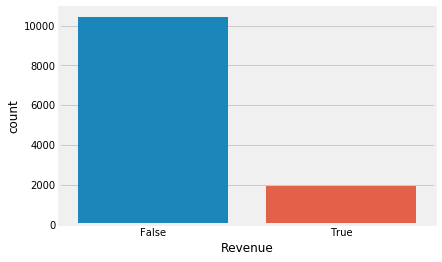

In [7]:
sns.countplot(df['Revenue'])

In [8]:
def composition(col):
    return df[col].value_counts().apply(lambda x: str(round(x/df[col].value_counts().sum()*100, 2))+'%')

In [9]:
composition('Revenue')

False    84.53%
True     15.47%
Name: Revenue, dtype: object

## Features

### Numerical

#### Distributions
We know that the distributions are not normal and contains lots of zeros.

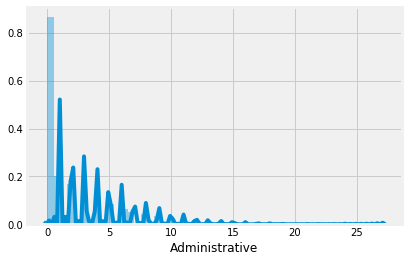

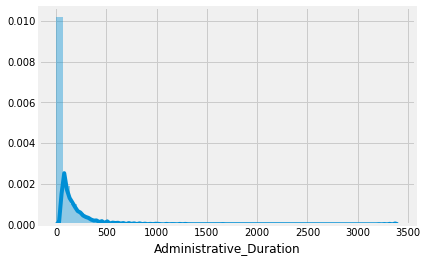

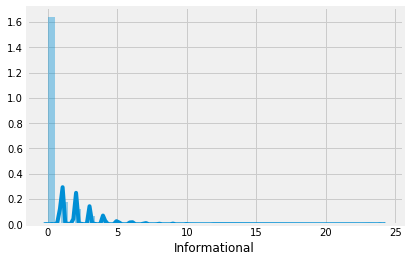

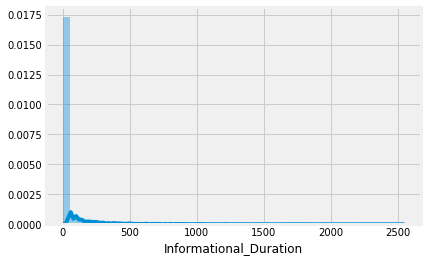

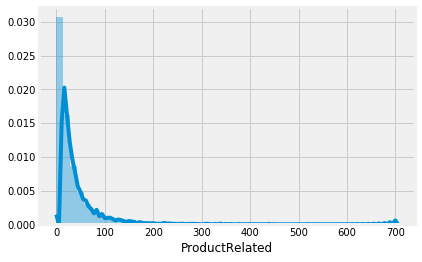

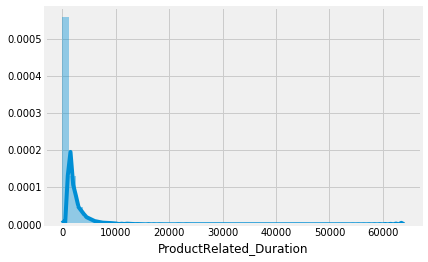

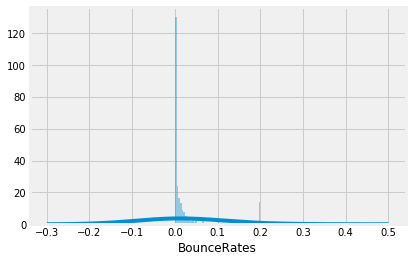

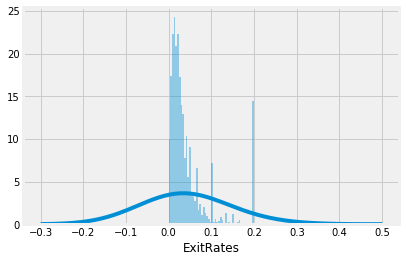

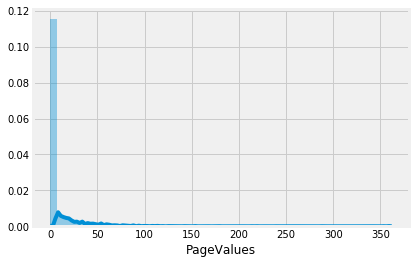

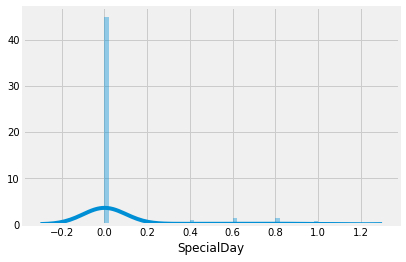

In [10]:
for column in num_feats:
    sns.distplot(df[column], kde_kws={'bw':0.1})
    plt.show()

#### Correlations
Some features are highly correlated with each other (multicollinearity).

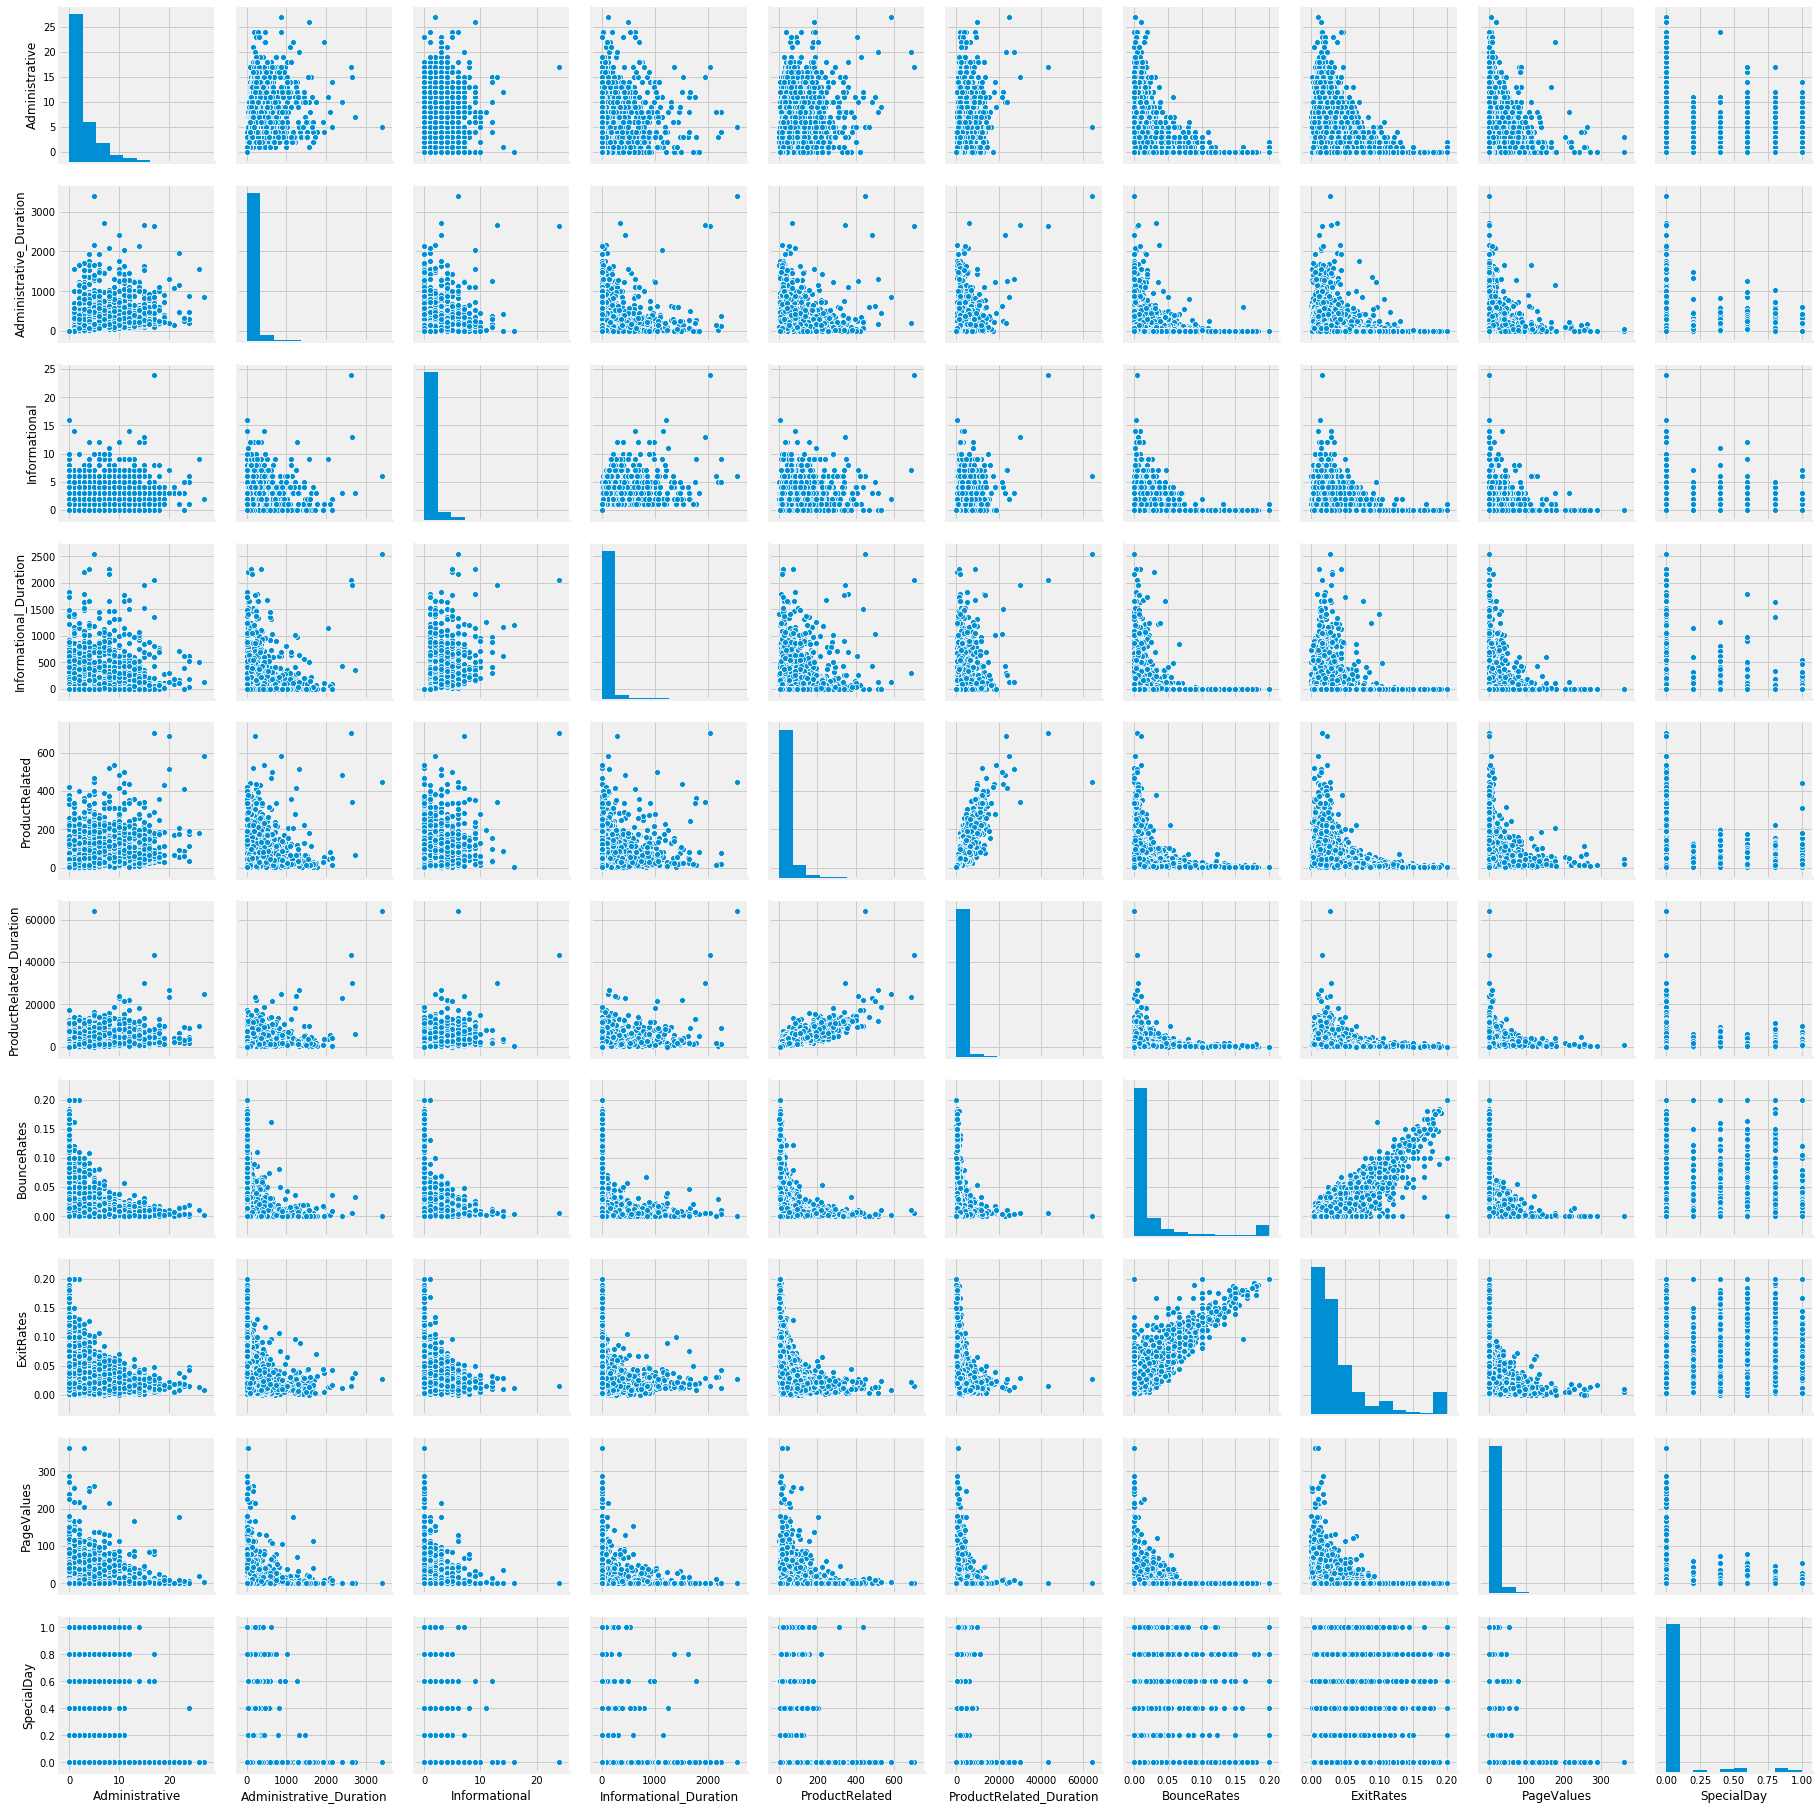

In [11]:
sns.pairplot(df[num_feats])

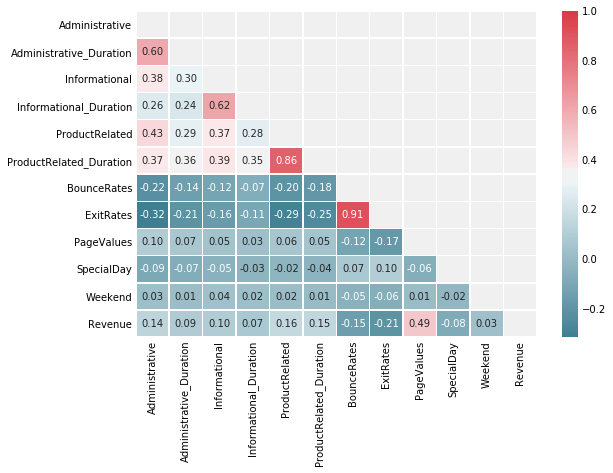

In [12]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(8, 6))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
dropSelf = np.zeros_like(corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
sns.heatmap(corr, cmap=colormap, linewidths=.5, annot=True, fmt=".2f", mask=dropSelf)
plt.show()

Administrative/Informational/ProductRelated pageview <--> its counterpart duration is HIGHLY correlated (60% - 86%)

Also note: ExitRates <--> BounceRates (90%!)

It's natural for PageValues to be correlated to Revenue (49%), since visitor will visit billing pages before purchase

In [13]:
pd.set_option('display.max_rows', None)
df.corr()['Revenue'].abs().sort_values(ascending=False)[1:]

PageValues                 0.492569
ExitRates                  0.207071
ProductRelated             0.158538
ProductRelated_Duration    0.152373
BounceRates                0.150673
Administrative             0.138917
Informational              0.095200
Administrative_Duration    0.093587
SpecialDay                 0.082305
Informational_Duration     0.070345
Weekend                    0.029295
Name: Revenue, dtype: float64

In [14]:
pd.set_option('display.max_rows', 10)

### Categorical

#### Distributions

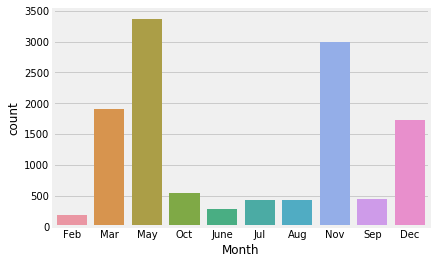

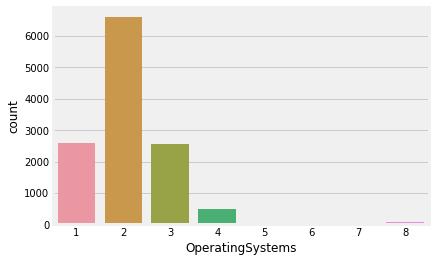

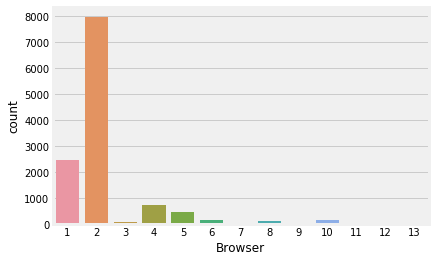

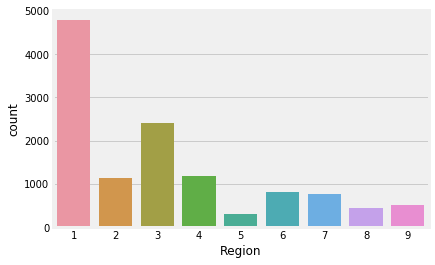

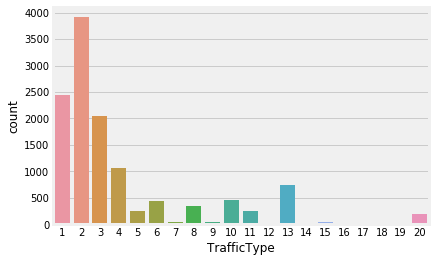

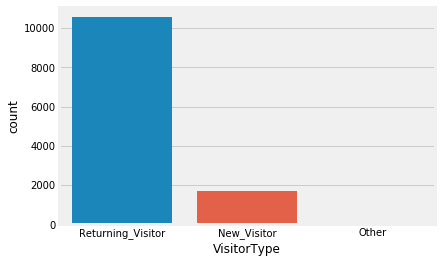

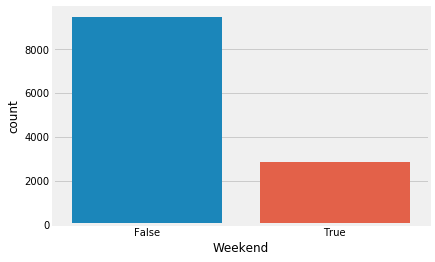

In [15]:
for feat in cat_feats:
    sns.countplot(df[feat])
    plt.show()

In [16]:
for feat in cat_feats:
    print(feat)
    print(composition(feat))
    print('\n')

Month
May     27.28%
Nov     24.31%
Mar     15.47%
Dec     14.01%
Oct      4.45%
Sep      3.63%
Aug      3.51%
Jul       3.5%
June     2.34%
Feb      1.49%
Name: Month, dtype: object


OperatingSystems
2    53.54%
1    20.97%
3    20.72%
4     3.88%
8     0.64%
6     0.15%
7     0.06%
5     0.05%
Name: OperatingSystems, dtype: object


Browser
2     64.57%
1     19.97%
4      5.97%
5      3.79%
6      1.41%
       ...  
13     0.49%
7       0.4%
12     0.08%
11     0.05%
9      0.01%
Name: Browser, Length: 13, dtype: object


Region
1    38.77%
3    19.49%
4     9.59%
2     9.21%
6     6.53%
7     6.17%
9     4.14%
8     3.52%
5     2.58%
Name: Region, dtype: object


TrafficType
2     31.74%
1     19.88%
3     16.64%
4      8.67%
13     5.99%
       ...  
14     0.11%
18     0.08%
16     0.02%
12     0.01%
17     0.01%
Name: TrafficType, Length: 20, dtype: object


VisitorType
Returning_Visitor    85.57%
New_Visitor          13.74%
Other                 0.69%
Name: VisitorType, dtype:

#### Correlations

In [17]:
def cramers_v(x, y):
    counts = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(counts)[0]
    n = counts.sum().sum()
    phi2 = chi2/n
    r,k = counts.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [18]:
result = []
for feat in cat_feats:
    result.append(cramers_v(df[feat], df['Revenue']))
    
pd.DataFrame(zip(cat_feats, result), columns = ['Feature', "Cramer's V"])

Feature  Cramer's V
0             Month    0.174619
1  OperatingSystems    0.074281
2           Browser    0.035701
3            Region    0.010078
4       TrafficType    0.169483
5       VisitorType    0.103962
6           Weekend    0.027599

## Insights

### Numerical

In [19]:
df[num_feats].mean()

Administrative                2.315166
Administrative_Duration      80.818611
Informational                 0.503569
Informational_Duration       34.472398
ProductRelated               31.731468
ProductRelated_Duration    1194.746220
BounceRates                   0.022191
ExitRates                     0.043073
PageValues                    5.889258
SpecialDay                    0.061427
dtype: float64

The average buying visitors:
- Are ~2x more likely to view more pages and stays in session longer
- 5x less likely to bounce.
- Have 14x larger page values. --> can be a natural indicator of purchase

In [20]:
df.groupby('Revenue').agg('mean')[num_feats]

Administrative  Administrative_Duration  Informational  \
Revenue                                                           
False          2.117732                73.740111       0.451833   
True           3.393606               119.483244       0.786164   

         Informational_Duration  ProductRelated  ProductRelated_Duration  \
Revenue                                                                    
False                 30.236237       28.714642              1069.987809   
True                  57.611427       48.210168              1876.209615   

         BounceRates  ExitRates  PageValues  SpecialDay  
Revenue                                                  
False       0.025317   0.047378    1.975998    0.068432  
True        0.005117   0.019555   27.264518    0.023166

Note that by median values, there's even clearer difference of visitor behavior.
Especially notable is product-related page and duration, bounce rates, and page values.
Seems like page values can be a proxy of cart amount.

In [21]:
df.groupby('Revenue').agg('median')[num_feats]

Administrative  Administrative_Duration  Informational  \
Revenue                                                           
False                 0                 0.000000              0   
True                  2                52.366667              0   

         Informational_Duration  ProductRelated  ProductRelated_Duration  \
Revenue                                                                    
False                       0.0              16                510.19000   
True                        0.0              29               1109.90625   

         BounceRates  ExitRates  PageValues  SpecialDay  
Revenue                                                  
False       0.004255   0.028571    0.000000         0.0  
True        0.000000   0.016000   16.758134         0.0

In [22]:
df['PageValues'].mean()

# e-commerce avg order value

5.889257862693596

In [23]:
df['BounceRates'].mean()

# e-commerce avg order value

0.02219138047072152

Number of pages viewed is moderately (+) correlated to duration for all type of pages.
Bounce rate & exit rate are strongly (+) correlated.
Seems like there are more outliers within non-buying group here (more diffused markers).

In [24]:
fig = px.scatter(df,
                 x="Administrative_Duration",
                 y="Administrative",
                 color="Revenue")
fig.update_layout(
    title='Correlation between Administrative and Administrative_Duration',
    xaxis_title='Administrative_Duration',
    yaxis_title='Administrative')
fig.show()

fig = px.scatter(df,
                 x="Informational_Duration",
                 y="Informational",
                 color="Revenue")
fig.update_layout(
    title='Correlation between Informational and Informational_Duration',
    xaxis_title='Informational_Duration',
    yaxis_title='Informational')
fig.show()

fig = px.scatter(df,
                 x="ProductRelated_Duration",
                 y="ProductRelated",
                 color="Revenue")
fig.update_layout(
    title='Correlation between ProductRelated and ProductRelated_Duration',
    xaxis_title='ProductRelated_Duration',
    yaxis_title='ProductRelated')
fig.show()

fig = px.scatter(df, x="BounceRates", y="ExitRates", color="Revenue")
fig.update_layout(
    title='Correlation between ExitRates and BounceRates',
    xaxis_title='BounceRates',
    yaxis_title='ExitRates')
fig.show()

Between buying and non-buying visitors, large difference of ProductRelated, ProductRelated_Duration, and PageValues jumps out.

In [25]:
df_buy = df[df['Revenue']==True]
df_buy.describe()

Administrative  Administrative_Duration  Informational  \
count     1908.000000              1908.000000    1908.000000   
mean         3.393606               119.483244       0.786164   
std          3.730527               201.114732       1.521176   
min          0.000000                 0.000000       0.000000   
25%          0.000000                 0.000000       0.000000   
50%          2.000000                52.366667       0.000000   
75%          5.000000               151.083333       1.000000   
max         26.000000              2086.750000      12.000000   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
count             1908.000000     1908.000000              1908.000000   
mean                57.611427       48.210168              1876.209615   
std                171.619131       58.267365              2312.214392   
min                  0.000000        0.000000                 0.000000   
25%                  0.000000       15.000000               541.906250   
50%                  0.000000       29.000000              1109.906250   
75%                 19.000000       57.000000              2266.011310   
max               1767.666667      534.000000             27009.859430   

       BounceRates    ExitRates   PageValues   SpecialDay  
count  1908.000000  1908.000000  1908.000000  1908.000000  
mean      0.005117     0.019555    27.264518     0.023166  
std       0.012185     0.016463    35.191954     0.123521  
min       0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.009521     3.641144     0.000000  
50%       0.000000     0.016000    16.758134     0.000000  
75%       0.006452     0.025000    38.897742     0.000000  
max       0.200000     0.200000   361.763742     1.000000

In [26]:
df_nope = df[df['Revenue']==False]
df_nope.describe()

Administrative  Administrative_Duration  Informational  \
count    10422.000000             10422.000000   10422.000000   
mean         2.117732                73.740111       0.451833   
std          3.202481               171.017970       1.211582   
min          0.000000                 0.000000       0.000000   
25%          0.000000                 0.000000       0.000000   
50%          0.000000                 0.000000       0.000000   
75%          3.000000                83.000000       0.000000   
max         27.000000              3398.750000      24.000000   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
count            10422.000000    10422.000000             10422.000000   
mean                30.236237       28.714642              1069.987809   
std                133.909306       40.744717              1803.797757   
min                  0.000000        0.000000                 0.000000   
25%                  0.000000        6.000000               151.000000   
50%                  0.000000       16.000000               510.190000   
75%                  0.000000       35.000000              1331.816667   
max               2549.375000      705.000000             63973.522230   

        BounceRates     ExitRates    PageValues    SpecialDay  
count  10422.000000  10422.000000  10422.000000  10422.000000  
mean       0.025317      0.047378      1.975998      0.068432  
std        0.051877      0.051231      9.072424      0.209054  
min        0.000000      0.000000      0.000000      0.000000  
25%        0.000000      0.015560      0.000000      0.000000  
50%        0.004255      0.028571      0.000000      0.000000  
75%        0.020000      0.053846      0.000000      0.000000  
max        0.200000      0.200000    246.758590      1.000000

### TrafficType

In [27]:
rev_true_labels = [i for i in df[df['Revenue']==True]['TrafficType'].value_counts().sort_index().index]
rev_true_values = [i for i in df[df['Revenue']==True]['TrafficType'].value_counts().sort_index().values]
rev_false_labels = [i for i in df[df['Revenue']==False]['TrafficType'].value_counts().sort_index().index]
rev_false_values = [i for i in df[df['Revenue']==False]['TrafficType'].value_counts().sort_index().values]

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, 
                    cols=2, 
                    specs=[[{'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=['Purchased', 'Did not purchase']
                   )
fig.add_trace(go.Pie(labels=rev_true_labels, 
                     values=rev_true_values, 
                     name="1", 
                     scalegroup='one',
                    ),
              1, 1
             )
fig.add_trace(go.Pie(labels=rev_false_labels, 
                     values=rev_false_values, 
                     name="0", 
                     scalegroup='one'),
              1, 2
             )

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="From which channels do visitors come from?",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Purchased', x=0.225, y=0.47, font_size=7, showarrow=False),
                 dict(text='Did not purchase', x=0.775, y=0.46, font_size=10, showarrow=False)])
fig.show()

In [28]:
# Supporting earlier point about page values being natural indicators of purchase

pd.crosstab(df.TrafficType, 
            df.Revenue,
            values=df.PageValues,
            aggfunc='median').round(2).sort_values(by=True, ascending=False)

Revenue      False  True 
TrafficType              
19             0.0  56.36
7              0.0  39.31
20             0.0  37.52
9              0.0  30.25
14             0.0  27.77
...            ...    ...
16             0.0   0.00
12             0.0    NaN
15             0.0    NaN
17             0.0    NaN
18             0.0    NaN

[20 rows x 2 columns]

In [29]:
def generate_stats(cat_feat):
    '''Function to generate summary dataframe
       cat_feat = name of categorical feature, string'''
    
    gb_rates = df.groupby(cat_feat).agg('mean')[[
        'BounceRates', 'PageValues']]

    ct_conversion = pd.crosstab(df[cat_feat], 
                                df['Revenue'],
                                margins=True, 
                                margins_name="TotalSessions"
    )
    ct_conversion['ConversionRates'] = ct_conversion[True]/ct_conversion['TotalSessions']

    core_stats = pd.DataFrame(data=zip(gb_rates.index,
                                          round(gb_rates.BounceRates*100, 2),
                                          round(gb_rates.PageValues, 2),
                                          round(ct_conversion.ConversionRates*100, 2),
                                          ct_conversion.TotalSessions),
                                 columns = [cat_feat,
                                            'BounceRates',
                                            'PageValues',
                                            'ConversionRates',
                                            'TotalSessions'])
    core_stats['ShareSize'] = round(core_stats.TotalSessions/sum(core_stats.TotalSessions)*100,2)
    
    return core_stats

generate_stats('TrafficType')

TrafficType  BounceRates  PageValues  ConversionRates  TotalSessions  \
0             1         3.23        3.46            10.69           2451   
1             2         0.85        8.30            21.65           3913   
2             3         3.33        3.28             8.77           2052   
3             4         1.63        7.04            15.43           1069   
4             5         0.95        7.71            21.54            260   
..          ...          ...         ...              ...            ...   
15           16         0.00        0.00            33.33              3   
16           17         5.00        0.00             0.00              1   
17           18         3.31        0.00             0.00             10   
18           19         2.58        3.50             5.88             17   
19           20         2.75       15.13            25.25            198   

    ShareSize  
0       19.88  
1       31.74  
2       16.64  
3        8.67  
4        2.11  
..        ...  
15       0.02  
16       0.01  
17       0.08  
18       0.14  
19       1.61  

[20 rows x 6 columns]

Visitors coming from channel 1, 2, 3, and 4 make up 77% of total sessions. The rest (23%) are contributed by remaining 12 small channels.

Intuitively busier channels would contribute larger sales & conversion and less bounce. This data can be used by marketers (collaborating with UX designers) to evaluate success of investments to each channel.
- Channel 1, 3: Despite attracting many visitors, conversion rates are lower and bounce rate are higher than Channel 2's.
- Channel 7, 8, 20: For small channels with less than 5% combined share, they have notably high conversion rates and page values.
- Channel 4, 10: Small - medium sized with promising stats, worth expanding.

Text(0.5, 1.0, 'Bounce Rate by Channel')

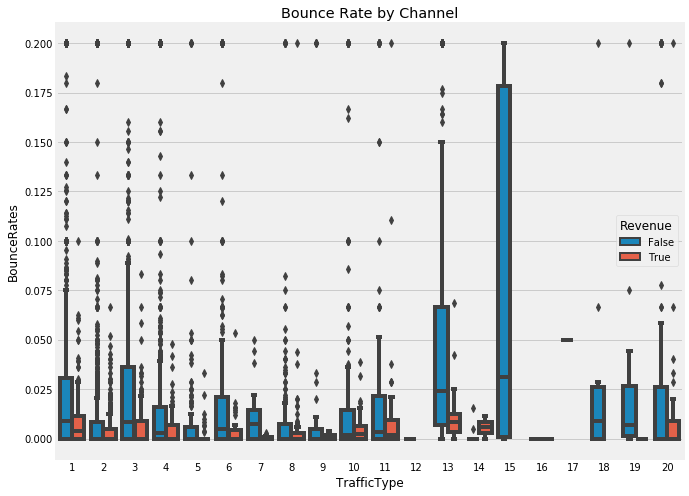

In [30]:
plt.figure(figsize=(10,8))
sns.boxplot(data = df,
            y = 'BounceRates',
            x = 'TrafficType',
            hue = 'Revenue'
           )
plt.title('Bounce Rate by Channel')

Text(0.5, 1.0, 'Bounce Rate by Channel')

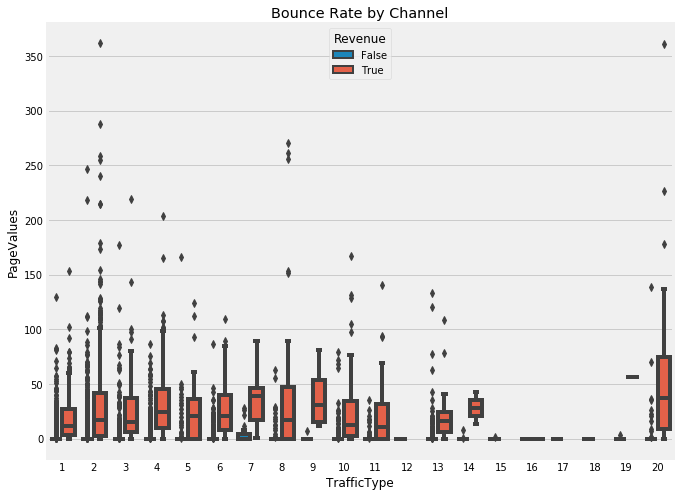

In [31]:
plt.figure(figsize=(10,8))
sns.boxplot(data = df,
            y = 'PageValues',
            x = 'TrafficType',
            hue = 'Revenue'
           )
plt.title('Bounce Rate by Channel')

### Month

In [32]:
generate_stats('Month')

Month  BounceRates  PageValues  ConversionRates  TotalSessions  ShareSize
0   Aug         1.82        5.94            17.55            433       3.51
1   Dec         2.01        6.83            12.51           1727      14.01
2   Feb         4.70        0.89             1.63            184       1.49
3   Jul         2.47        4.10            15.28            432       3.50
4  June         3.51        3.39            10.07            288       2.34
5   Mar         2.17        3.96            10.07           1907      15.47
6   May         2.69        5.43            10.85           3364      27.28
7   Nov         1.93        7.13            25.35           2998      24.31
8   Oct         1.18        8.65            20.95            549       4.45
9   Sep         1.22        7.56            19.20            448       3.63

In [33]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig = go.Figure()
fig.add_trace(go.Scatter(x=months, 
                         y=[i for i in df[df['Revenue']==True]['Month'].value_counts().reindex(months).values], 
                         name = 'Purchased',
                         line=dict(color='royalblue', width=4)))
fig.add_trace(go.Scatter(x=months, 
                         y=[i for i in df[df['Revenue']==False]['Month'].value_counts().reindex(months).values], 
                         name='Did not purchase',
                         line=dict(color='firebrick', width=4)))
fig.add_trace(go.Scatter(x=months, 
                         y=[i for i in df['Month'].value_counts().reindex(months).values], 
                         name='All',
                         line=dict(color='slategray', width=4)))

fig.update_layout(title='Buying Behaviour Related to Month',
                   xaxis_title='Month',
                   yaxis_title='Sessions')


fig.show()

(Due to missing Jan/Apr data, a full trend analysis can't be performed.)

There was a huge spike of visitors on May, although only 10.85% sessions led to purchase. The e-commerce website is based in Turkey, a country with 98% muslim population. May is festive season in Turkey, with ramadan and Eid Al-Fitr (see crosstab with special day below). Maybe people used the website to check prices online, but do their shopping offline. There's huge opportunity here for marketers to devise special Eid campaign peaking on mid ramadan to aggresively convert customers. Limited-time offer can be used to create urgency to purchase.

From engineering standpoint it's also important to increase server capacity in anticipation of these surges on May, November, and February. When it has passed the capacity can be reverted to normal (May to June decreased 91%). It's a shame if revenues are lost due to technical issues. These are also annoying to visitors and may drive them away for a long time.

Interestingly, November and February surges were not related to any special days. Throughout the year, November saw the most conversions, 1 in 4 sessions resulted in a purchase. These purchases were also in higher value than average. Might be interesting to look into what product category is popular during this time. Buying visitors viewed the most product-related pages during November. (Turkey is a four-season country, is it related to winter prep?)

In [34]:
pd.crosstab(df.Month, df.SpecialDay)

SpecialDay   0.0  0.2  0.4  0.6  0.8  1.0
Month                                    
Aug          433    0    0    0    0    0
Dec         1727    0    0    0    0    0
Feb          105   15   21   19   19    5
Jul          432    0    0    0    0    0
June         288    0    0    0    0    0
Mar         1907    0    0    0    0    0
May         2192  163  222  332  306  149
Nov         2998    0    0    0    0    0
Oct          549    0    0    0    0    0
Sep          448    0    0    0    0    0

Text(0.5, 1.0, 'Number of product-related pages viewed (monthly)')

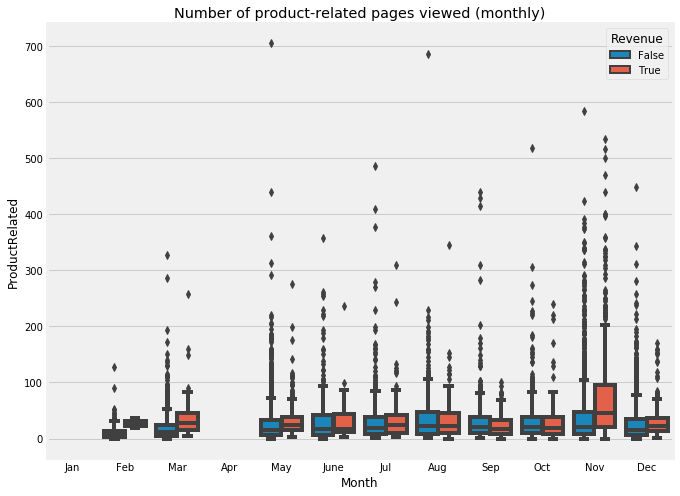

In [35]:
plt.figure(figsize=(10,8))
sns.boxplot(data = df,
            y = 'ProductRelated',
            x = 'Month',
            order = months,
            hue = 'Revenue'
           )
plt.title('Number of product-related pages viewed (monthly)')

### Region

In [36]:
regions=df["Region"].value_counts()

# pie plot
fig = px.pie(regions,
             values=regions.values,
             names=regions.index,
             title="From what regions do visitors come from?",
             color_discrete_sequence=px.colors.diverging.curl)
fig.update_traces(rotation=-90, textinfo="percent+label")
fig.show()

In [37]:
generate_stats('Region')

Region  BounceRates  PageValues  ConversionRates  TotalSessions  ShareSize
0       1         2.21        5.90            16.13           4780      38.77
1       2         2.29        5.91            16.55           1136       9.21
2       3         2.25        5.34            14.52           2403      19.49
3       4         2.32        5.80            14.81           1182       9.59
4       5         2.07        9.25            16.35            318       2.58
5       6         2.37        4.80            13.91            805       6.53
6       7         2.04        6.26            15.64            761       6.17
7       8         1.92        4.26            12.90            434       3.52
8       9         2.17        8.94            16.83            511       4.14

Most regions' stats are more or less in-line with e-commerce average stats. Region 5 & 9 are the smallest by size yet hold the above average page values and conversion rate. Might be interesting to look into what product category these regions purchase. The company should be establishing regional teams already, with number of personnels proportional to the regional demands (share %). 

Text(0.5, 1.0, 'Page values per Region')

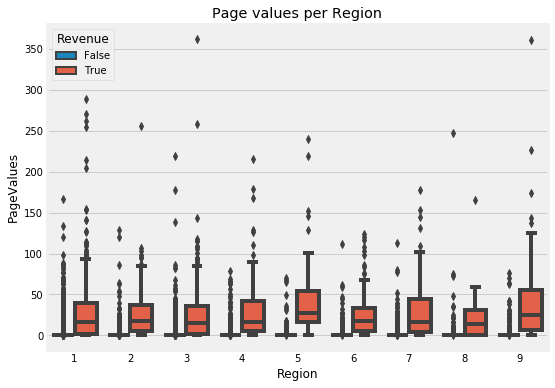

In [38]:
plt.figure(figsize=(8,6))
sns.boxplot(data = df,
            y = 'PageValues',
            x = 'Region',
            hue = 'Revenue'
           )
plt.title('Page values per Region')

### OS & Browser

In [39]:
generate_stats('OperatingSystems')

OperatingSystems  BounceRates  PageValues  ConversionRates  TotalSessions  \
0                 1         2.71        5.19            14.66           2585   
1                 2         1.66        6.79            17.50           6601   
2                 3         3.31        3.43            10.49           2555   
3                 4         1.23        8.15            17.78            478   
4                 5         1.31        4.36            16.67              6   
5                 6         3.70        8.66            10.53             19   
6                 7         3.99        0.00            14.29              7   
7                 8         3.38       18.98            21.52             79   

   ShareSize  
0      20.97  
1      53.54  
2      20.72  
3       3.88  
4       0.05  
5       0.15  
6       0.06  
7       0.64

In [40]:
generate_stats('Browser')

Browser  BounceRates  PageValues  ConversionRates  TotalSessions  \
0         1         2.62        5.51            14.83           2462   
1         2         2.14        5.72            15.36           7961   
2         3         3.76        2.58             4.76            105   
3         4         1.72        6.72            17.66            736   
4         5         1.96        7.98            18.42            467   
..      ...          ...         ...              ...            ...   
8         9         2.00        0.00             0.00              1   
9        10         1.49        7.06            19.63            163   
10       11         1.31        4.36            16.67              6   
11       12         2.59        2.12            30.00             10   
12       13         3.44       26.27            26.23             61   

    ShareSize  
0       19.97  
1       64.57  
2        0.85  
3        5.97  
4        3.79  
..        ...  
8        0.01  
9        1.32  
10       0.05  
11       0.08  
12       0.49  

[13 rows x 6 columns]

Devs need to know what technology 'stack' the visitors use to determine which OS/browser combination to prioritize.
* OS 2 is the most popular OS.
* Browser 2 is the most popular browser.
Naturally the most popular stack is OS 2/Browser 2, followed by OS 3/Browser 2 and OS 1/Browser 1. These three represent 78% of sessions and should be the focus of dev and UX/UI. For example it would be efficient to release updates to this group first, evaluate, fix bugs if any, then expand to other combinations. 

With above average bounce rates in OS 3/Browser 2 and OS 1/Browser 1, it's worth investigating if the problem can be traced to  load time, layouts, etc.

With rapid advancements of technology, it's advised to monitor this data periodically.

In [41]:
combo = pd.crosstab(df.OperatingSystems, df.Browser, margins=True)
combo

Browser              1     2    3    4    5    6   7    8  9   10  11  12  13  \
OperatingSystems                                                                
1                 2153   280    0    3    5    4   0  135  0    3   0   0   2   
2                   16  5059    1  732  430  155  39    0  0  160   0   4   5   
3                    1  2416  104    0    6   11   9    0  1    0   0   6   1   
4                  279   174    0    1   21    3   0    0  0    0   0   0   0   
5                    0     0    0    0    0    0   0    0  0    0   6   0   0   
6                    0    15    0    0    3    0   1    0  0    0   0   0   0   
7                    7     0    0    0    0    0   0    0  0    0   0   0   0   
8                    6    17    0    0    2    1   0    0  0    0   0   0  53   
All               2462  7961  105  736  467  174  49  135  1  163   6  10  61   

Browser             All  
OperatingSystems         
1                  2585  
2                  6601  
3                  2555  
4                   478  
5                     6  
6                    19  
7                     7  
8                    79  
All               12330

In [42]:
fig = go.Figure(data=go.Heatmap(
                   z=combo.iloc[:-1,:-1].where(combo>0).values,
                   x=[str(i) for i in range(1, 14)],
                   y=[str(i) for i in range(1, 9)],
                   hoverongaps = False,
 colorscale='YlGnBu'))
fig.update_layout(title="Which OS-browser combination do visitors prefer?",
                   xaxis_title='Browser',
                   yaxis_title='Operating System')
fig.show()

In [43]:
pd.crosstab(df.OperatingSystems, df.Browser, aggfunc='mean', values=df.BounceRates, margins=True)

Browser                  1         2         3         4         5         6  \
OperatingSystems                                                               
1                 0.027935  0.017997       NaN  0.011438  0.004951  0.005515   
2                 0.005724  0.016204  0.010870  0.017202  0.020408  0.017092   
3                 0.008845  0.033106  0.037860       NaN  0.013413  0.022903   
4                 0.013310  0.011603       NaN  0.000000  0.002657  0.030952   
5                      NaN       NaN       NaN       NaN       NaN       NaN   
6                      NaN  0.031201       NaN       NaN  0.011381       NaN   
7                 0.039930       NaN       NaN       NaN       NaN       NaN   
8                 0.033333  0.035294       NaN       NaN  0.101389  0.200000   
All               0.026173  0.021365  0.037603  0.017155  0.019643  0.018483   

Browser                  7         8     9        10        11        12  \
OperatingSystems                                                           
1                      NaN  0.031124   NaN  0.040000       NaN       NaN   
2                 0.014815       NaN   NaN  0.014444       NaN  0.035098   
3                 0.029452       NaN  0.02       NaN       NaN  0.019697   
4                      NaN       NaN   NaN       NaN       NaN       NaN   
5                      NaN       NaN   NaN       NaN  0.013095       NaN   
6                 0.200000       NaN   NaN       NaN       NaN       NaN   
7                      NaN       NaN   NaN       NaN       NaN       NaN   
8                      NaN       NaN   NaN       NaN       NaN       NaN   
All               0.021283  0.031124  0.02  0.014914  0.013095  0.025857   

Browser                 13       All  
OperatingSystems                      
1                 0.200000  0.027074  
2                 0.045714  0.016566  
3                 0.000000  0.033137  
4                      NaN  0.012304  
5                      NaN  0.013095  
6                      NaN  0.036955  
7                      NaN  0.039930  
8                 0.027701  0.033809  
All               0.034373  0.022191

### VisitorType

In [44]:
visitors=df['VisitorType'].value_counts()

fig = px.pie(visitors,
             values=visitors.values,
             names=visitors.index,
             title="What's the composition of our visitors?",
             color_discrete_sequence=px.colors.diverging.Portland)
fig.update_traces(rotation=-90, textinfo="percent+label")
fig.show()

Numerous studies have shown that websites tend to have more new visitors and fewer returning visitors. It's great that the e-commerce has many returning visitors as large as 85%, representing success in keeping people interested after first visit.

In [45]:
visitors=[i for i in df['VisitorType'].unique()]

fig = go.Figure(data=[
    go.Bar(name='Purchased', 
           x=visitors, 
           y=[i for i in df[df['Revenue']==True]['VisitorType'].value_counts().reindex(visitors).values], 
           marker_color='royalblue'
          ),
    go.Bar(name='Did not purchase', 
           x=visitors, 
           y=[i for i in df[df['Revenue']==False]['VisitorType'].value_counts().reindex(visitors).values], 
           marker_color='firebrick'),
    go.Bar(name='All', 
           x=visitors, 
           y=[i for i in df['VisitorType'].value_counts().reindex(visitors).values], 
           marker_color='slategrey')
])
# Change the bar mode
fig.update_layout(barmode='group',
                 title="Sessions by Visitor Type",
                   xaxis_title='Visitor Type',
                   yaxis_title='Number of Session')
fig.show()

Theoretically, returning visitors bounce less, view more pages per session, and have higher session durations. They also tend to have higher conversion rates and higher sales.

However in this case the data is telling a different story. In average, turns out new visitors are more likely to purchase with higher value and bounce much less. The e-commerce may be directing enticing offers to new visitors (e.g. 20% off for your first purchase). New visitors' average page values is even double the returning visitor's. Meanwhile, the returning visitors do stay in-session much longer.

So, there's a huge missed opportunity here to engage returning visitors. According to studies, one of the strategies that should be employed is personalization. To tap the potential buying power, marketers & data scientists can build a recommendation system based on past purchases. Marketers can also implement CRM to increase transactions and inspire loyalty, for example member tier feature (platinum, gold, silver). Offer incentives for returning visitors to buy more and buy often. From a UX/CS standpoint make sure that the customer journey is pleasant so that a customer is inclined to buy again after the frist experience.

If the company is concerned with new user acquisition, current strategies may be evaluated to increase new visitor rate (currently only 13%).

In [46]:
generate_stats('VisitorType')

VisitorType  BounceRates  PageValues  ConversionRates  TotalSessions  \
0        New_Visitor         0.53       10.77            24.91           1694   
1              Other         3.86       18.19            18.82             85   
2  Returning_Visitor         2.48        5.01            13.93          10551   

   ShareSize  
0      13.74  
1       0.69  
2      85.57

In [47]:
df.groupby(['VisitorType', 'Revenue']).agg('mean')[['ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'PageValues']]

ProductRelated  ProductRelated_Duration  \
VisitorType       Revenue                                            
New_Visitor       False         16.650157               557.490745   
                  True          22.289100               874.223020   
Other             False          9.681159               410.871570   
                  True          24.500000              1258.392186   
Returning_Visitor False         30.549169              1146.782797   
                  True          55.909524              2170.579290   

                           BounceRates  PageValues  
VisitorType       Revenue                           
New_Visitor       False       0.006605    1.367760  
                  True        0.001212   39.119181  
Other             False       0.047276    1.465247  
                  True        0.000926   90.325123  
Returning_Visitor False       0.027772    2.065076  
                  True        0.006284   23.174969

Text(0.5, 1.0, 'Number of product-related pages viewed by VisitorType')

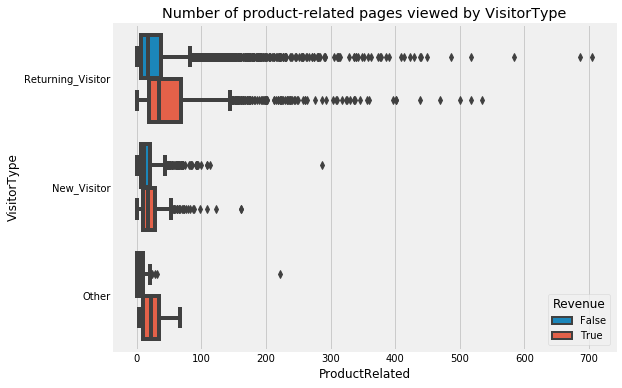

In [48]:
plt.figure(figsize=(8,6))
sns.boxplot(data = df,
            x = 'ProductRelated',
            y = 'VisitorType',
            hue = 'Revenue'
           )
plt.title('Number of product-related pages viewed by VisitorType')

Considering very small population (0.7%) and the largest page values range, type 'Other' may refer to VIPs?

Text(0.5, 1.0, 'PageValues of VisitorType')

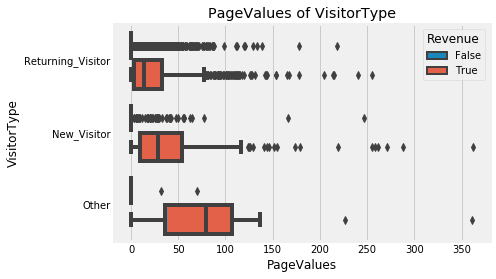

In [49]:
sns.boxplot(data = df,
            x = 'PageValues',
            y = 'VisitorType',
            hue = 'Revenue'
           )
plt.title('PageValues of VisitorType')

Channel 2 is very successful in attracting new visitors amongst other channels (also the larger channel). However channel 5 & 8, the smaller channels, comprise more of new visitors than returning visitors. Vice versa with channel 1, 3, 4. This information can be used to implement more effective targeted offers based on visitor type.

In [50]:
traffic_visitor = pd.crosstab(df.TrafficType, df.VisitorType, margins=True)
traffic_visitor['NewSize'] = round(traffic_visitor['New_Visitor']/1694*100, 2)
traffic_visitor['ReturnSize'] = round(traffic_visitor['Returning_Visitor']/10551*100, 2)
traffic_visitor['NewRatio'] = round(traffic_visitor['New_Visitor']/traffic_visitor['All']*100, 2)
traffic_visitor

VisitorType  New_Visitor  Other  Returning_Visitor    All  NewSize  \
TrafficType                                                          
1                     37      7               2407   2451     2.18   
2                    936     11               2966   3913    55.25   
3                    140      7               1905   2052     8.26   
4                     99      0                970   1069     5.84   
5                    149      1                110    260     8.80   
...                  ...    ...                ...    ...      ...   
17                     0      0                  1      1     0.00   
18                     1      0                  9     10     0.06   
19                     1      0                 16     17     0.06   
20                    17     52                129    198     1.00   
All                 1694     85              10551  12330   100.00   

VisitorType  ReturnSize  NewRatio  
TrafficType                        
1                 22.81      1.51  
2                 28.11     23.92  
3                 18.06      6.82  
4                  9.19      9.26  
5                  1.04     57.31  
...                 ...       ...  
17                 0.01      0.00  
18                 0.09     10.00  
19                 0.15      5.88  
20                 1.22      8.59  
All              100.00     13.74  

[21 rows x 7 columns]

### Weekend

In [51]:
df['Day'] = df['Weekend'].apply(lambda x: 'Weekday' if x == False else 'Weekend')

In [52]:
weekend=[i for i in df['Day'].unique()]

fig = go.Figure(data=[
    go.Bar(name='Purchased', 
           x=weekend, 
           y=[i for i in df[df['Revenue']==True]['Day'].value_counts().reindex(weekend).values], 
           marker_color='royalblue'
          ),
    go.Bar(name='Did not purchase', 
           x=weekend, 
           y=[i for i in df[df['Revenue']==False]['Day'].value_counts().reindex(weekend).values], 
           marker_color='firebrick'),
    go.Bar(name='All', 
           x=weekend, 
           y=[i for i in df['Day'].value_counts().reindex(weekend).values], 
           marker_color='slategrey'),
])
# Change the bar mode
fig.update_layout(barmode='group',
                 title="Sessions in Weekday vs Weekend",
                   xaxis_title='Day',
                   yaxis_title='Number of Session')
fig.show()

In [53]:
composition('Day')

# somewhat in-line with number of days - 71.43% and 28.57% respectively

Weekday    76.74%
Weekend    23.26%
Name: Day, dtype: object

In [54]:
generate_stats('Day')

Day  BounceRates  PageValues  ConversionRates  TotalSessions  ShareSize
0  Weekday         2.34        5.77            14.89           9462      76.74
1  Weekend         1.81        6.29            17.40           2868      23.26

In [55]:
df.groupby('Day').agg('median')

Administrative  Administrative_Duration  Informational  \
Day                                                               
Weekday               1                      5.0              0   
Weekend               1                     19.0              0   

         Informational_Duration  ProductRelated  ProductRelated_Duration  \
Day                                                                        
Weekday                     0.0              17               585.089178   
Weekend                     0.0              20               650.820833   

         BounceRates  ExitRates  PageValues  SpecialDay  Weekend  Revenue  
Day                                                                        
Weekday     0.003279   0.026498         0.0         0.0    False    False  
Weekend     0.002546   0.023037         0.0         0.0     True    False

Visitors do view more pages for longer durations during the weekend. Marketers and content creators are advised to post more elaborate content that take more time to digest on weekends. Visitors are also more inclined to purchase on weekends, so limited-time offers (e.g. discounts expiring on Monday) may be employed to seal the deal.

In [56]:
pd.concat([pd.DataFrame(df.pivot_table(index='Day')[num_feats].iloc[0]/5),
pd.DataFrame(df.pivot_table(index='Day').iloc[1]/2)], axis=1)

Weekday    Weekend
Administrative            0.453371   1.237273
Administrative_Duration  15.871948  42.815834
Informational             0.095709   0.293061
Informational_Duration    6.521327  20.313923
ProductRelated            6.267491  16.515690
...                            ...        ...
ExitRates                 0.008949   0.018774
PageValues                1.153314   3.147010
SpecialDay                0.012653   0.027685
Revenue                        NaN   0.086994
Weekend                        NaN   0.500000

[12 rows x 2 columns]

Text(0.5, 1.0, 'Duration of product-related pages viewed in Weekday vs Weekend')

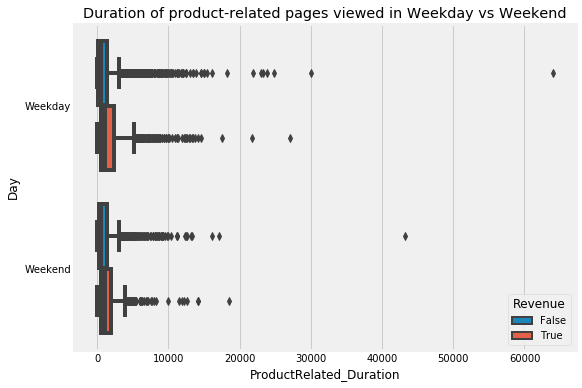

In [57]:
plt.figure(figsize=(8,6))
sns.boxplot(data = df,
            x = 'ProductRelated_Duration',
            y = 'Day',
            hue = 'Revenue'
           )
plt.title('Duration of product-related pages viewed in Weekday vs Weekend')